# Process

# Todo
- postgres db (import export)
- analyze data directly from db
  - 02_eda
- create features
  - trend
  - weekend
  - is_nice_day
- analyze features
  - violin plot
- train model
  - all
  - cross-validation
  - convolution rnn
- validate
  - plot
  - mse
  - gütemass
- create predictions
  - some examples
  - where is it cheapest to go tomorrow? as LLM and geo
- modellhypothesen
  - is is more expensive on weekends???
  - analyse


In [14]:
!pip install sqlalchemy pandas psycopg2-binary matplotlib seaborn tensorflow setuptools scikit-learn

In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Import
You first have to import the data from `ds/dump.sql`. To do so run `docker compose up -d` and `data/scripts/import.sh`.
This will import the data from the database dump. Originally the data was stored in a GCP cloud SQL instance and the dump was exported with the script `data/scripts/export.sh`

In [234]:
import matplotlib.pyplot as plt
import datetime
import random
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from tensorflow import keras
from sklearn.model_selection import KFold


url = URL.create(
    drivername="postgresql",
    username="postgres",
    password="password",
    host="localhost",
    database="data",
)
db = create_engine(url)
conn = db.connect()

data = pd.read_sql_query("""
                         SELECT 
                         P.resort, P.date, 
                         MAX(P.price) as max_price, 
                         AVG(P.price) as avg_price, 
                         MIN(P.price) as min_price,
                         MAX(W.apparent_temperature) as max_apparent_temperature,
                         AVG(W.apparent_temperature) as avg_apparent_temperature,
                         MIN(W.apparent_temperature) as min_apparent_temperature,
                         MAX(W.precipitation) as max_precipitation,
                         AVG(W.precipitation) as avg_precipitation,
                         MIN(W.precipitation) as min_precipitation,
                         MAX(W.temperature_2m) as max_temp,
                         AVG(W.temperature_2m) as avg_temp,
                         MIN(W.temperature_2m) as min_temp,
                         MAX(W.wind_speed_100m) as max_wind,
                         AVG(W.wind_speed_100m) as avg_wind,
                         MIN(W.wind_speed_100m) as min_wind,
                         MAX(W.rain) as max_rain,
                         MIN(W.rain) as min_rain,
                         AVG(W.rain) as avg_rain,
                         MAX(W.snow_depth) as max_snow_depth,
                         MAX(W.cloud_cover) as max_cloud_cover,
                         SUM(W.snowfall) as sum_snow,
                         SUM(W.sunshine_duration) as sum_sunshine
                         FROM prices as P
                         INNER JOIN weather as W 
                         ON Date(W.date) = Date(P.date)
                         AND W.resort = P.resort
                         GROUP BY P.resort, P.date
                         """, conn)
data.index = pd.to_datetime(data["date"]).apply(lambda x: x.date())

# Feature enginnering
data["weekday"] = pd.to_datetime(data["date"]).apply(lambda x: x.date().weekday())
data["weekend"] = pd.to_datetime(data["date"]).apply(lambda x: 1 if x.date().weekday() > 4 else 0)
data.describe()

max_price   avg_price   min_price  max_apparent_temperature  \
count  197.000000  197.000000  197.000000                197.000000   
mean    69.345178   64.368646   61.631980                 -0.633015   
std     10.250567    8.288984    7.340678                  6.609045   
min     55.000000   51.188216   49.000000                -12.862125   
25%     64.000000   58.394248   55.000000                 -4.816090   
50%     67.000000   64.000000   64.000000                 -2.410789   
75%     74.000000   68.236061   67.000000                  2.164895   
max     94.500000   90.430836   83.500000                 22.771229   

       avg_apparent_temperature  min_apparent_temperature  max_precipitation  \
count                197.000000                197.000000         197.000000   
mean                  -5.410601                -10.957961           0.984264   
std                    5.606393                  5.874564           1.245361   
min                  -17.148169                -25.281313           0.000000   
25%                   -9.251680                -15.092754           0.000000   
50%                   -6.586293                -11.365122           0.400000   
75%                   -2.143950                 -6.616779           1.700000   
max                   12.119329                  1.769660           6.000000   

       avg_precipitation  min_precipitation    max_temp  ...    min_wind  \
count         197.000000         197.000000  197.000000  ...  197.000000   
mean            0.212225           0.000508    2.384901  ...    5.096181   
std             0.302477           0.007125    5.862051  ...    5.096970   
min             0.000000           0.000000   -8.233500  ...    0.360000   
25%             0.000000           0.000000   -1.333500  ...    1.484318   
50%             0.070833           0.000000    0.925000  ...    3.075841   
75%             0.333333           0.000000    4.561000  ...    7.208994   
max             2.037500           0.100000   22.530500  ...   27.852928   

         max_rain  min_rain    avg_rain  max_snow_depth  max_cloud_cover  \
count  197.000000     197.0  197.000000      193.000000       197.000000   
mean     0.166497       0.0    0.031113        2.014301        96.408630   
std      0.431058       0.0    0.089037        0.366185        11.961595   
min      0.000000       0.0    0.000000        1.360000        30.000002   
25%      0.000000       0.0    0.000000        1.690000       100.000000   
50%      0.000000       0.0    0.000000        2.060000       100.000000   
75%      0.100000       0.0    0.008333        2.260000       100.000000   
max      3.200000       0.0    0.579167        2.810000       100.000000   

           sum_snow  sum_sunshine     weekday     weekend  
count    197.000000  1.970000e+02  197.000000  197.000000  
mean    5866.631017  5.449657e+07    3.060914    0.299492  
std    10869.360097  5.444639e+07    2.004165    0.459203  
min        0.000000  0.000000e+00    0.000000    0.000000  
25%        0.000000  1.026440e+07    1.000000    0.000000  
50%      755.580000  4.102183e+07    3.000000    0.000000  
75%     6957.300166  8.228880e+07    5.000000    1.000000  
max    76383.718110  2.654008e+08    6.000000    1.000000  

[8 rows x 24 columns]

In [79]:
def get_mondays(start, end):
    start = start - datetime.timedelta(days=start.weekday())
    end = end - datetime.timedelta(days=end.weekday())
    current = start
    while current <= end:
        yield current
        current = current + datetime.timedelta(days=7)

def print_groups(groups, cols):
    fig = plt.figure(figsize=(40, 20))
    for index, (group_name, df) in enumerate(groups):
        axis = fig.add_subplot(
            5,1,index+1,
            yticks=[],
            title=group_name
        )
        #df = df[df.index >= datetime.datetime.strptime("2024-02-19", '%Y-%m-%d').date()]
        
        for monday in get_mondays(df.index.min(), df.index.max()):
            axis.vlines(monday, 0, 1, color='black', linestyle='--')
            axis.text(monday,0, monday.strftime('%a %Y-%m-%d') ,rotation=90)

        for index, (col, color, pltarea) in enumerate(cols):
            ax = axis.twinx()
            if index > 0:
                ax.plot(df.index, df[col], color=color)
                if len(pltarea):
                    ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
                ax.set_yticks([])
                sax = ax.secondary_yaxis(1.0 + 0.02 * (index - 1))
                sax.set_ylabel(col, color=color)
                sax.tick_params(axis='y', labelcolor=color)
            else:
                ax.scatter(df.index, df[col], color=color, marker='x')
                if len(pltarea):
                    ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
                ax.yaxis.set_ticks_position("left")
                ax.yaxis.set_label_position("left")
                ax.set_ylabel(col, color=color)
                ax.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    return fig

def print_violins(groups, drop_cols=[]):
    fig = plt.figure(figsize=(20, 35)) 
    for index, (group_name, df) in enumerate(groups):
        df = df.drop(columns=drop_cols)
        df_mean = df.mean()
        df_std = df.std()
        df_std = (df - df_mean) / df_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        axis = fig.add_subplot(
            2*len(groups.groups),1,index+1,
            title=f"{group_name} - Features"
        )
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std, ax=axis)
        ax.tick_params(axis='x', labelrotation=45)
    fig.tight_layout()
    return fig

def flatten(matrix):
    return [item for row in matrix for item in row]

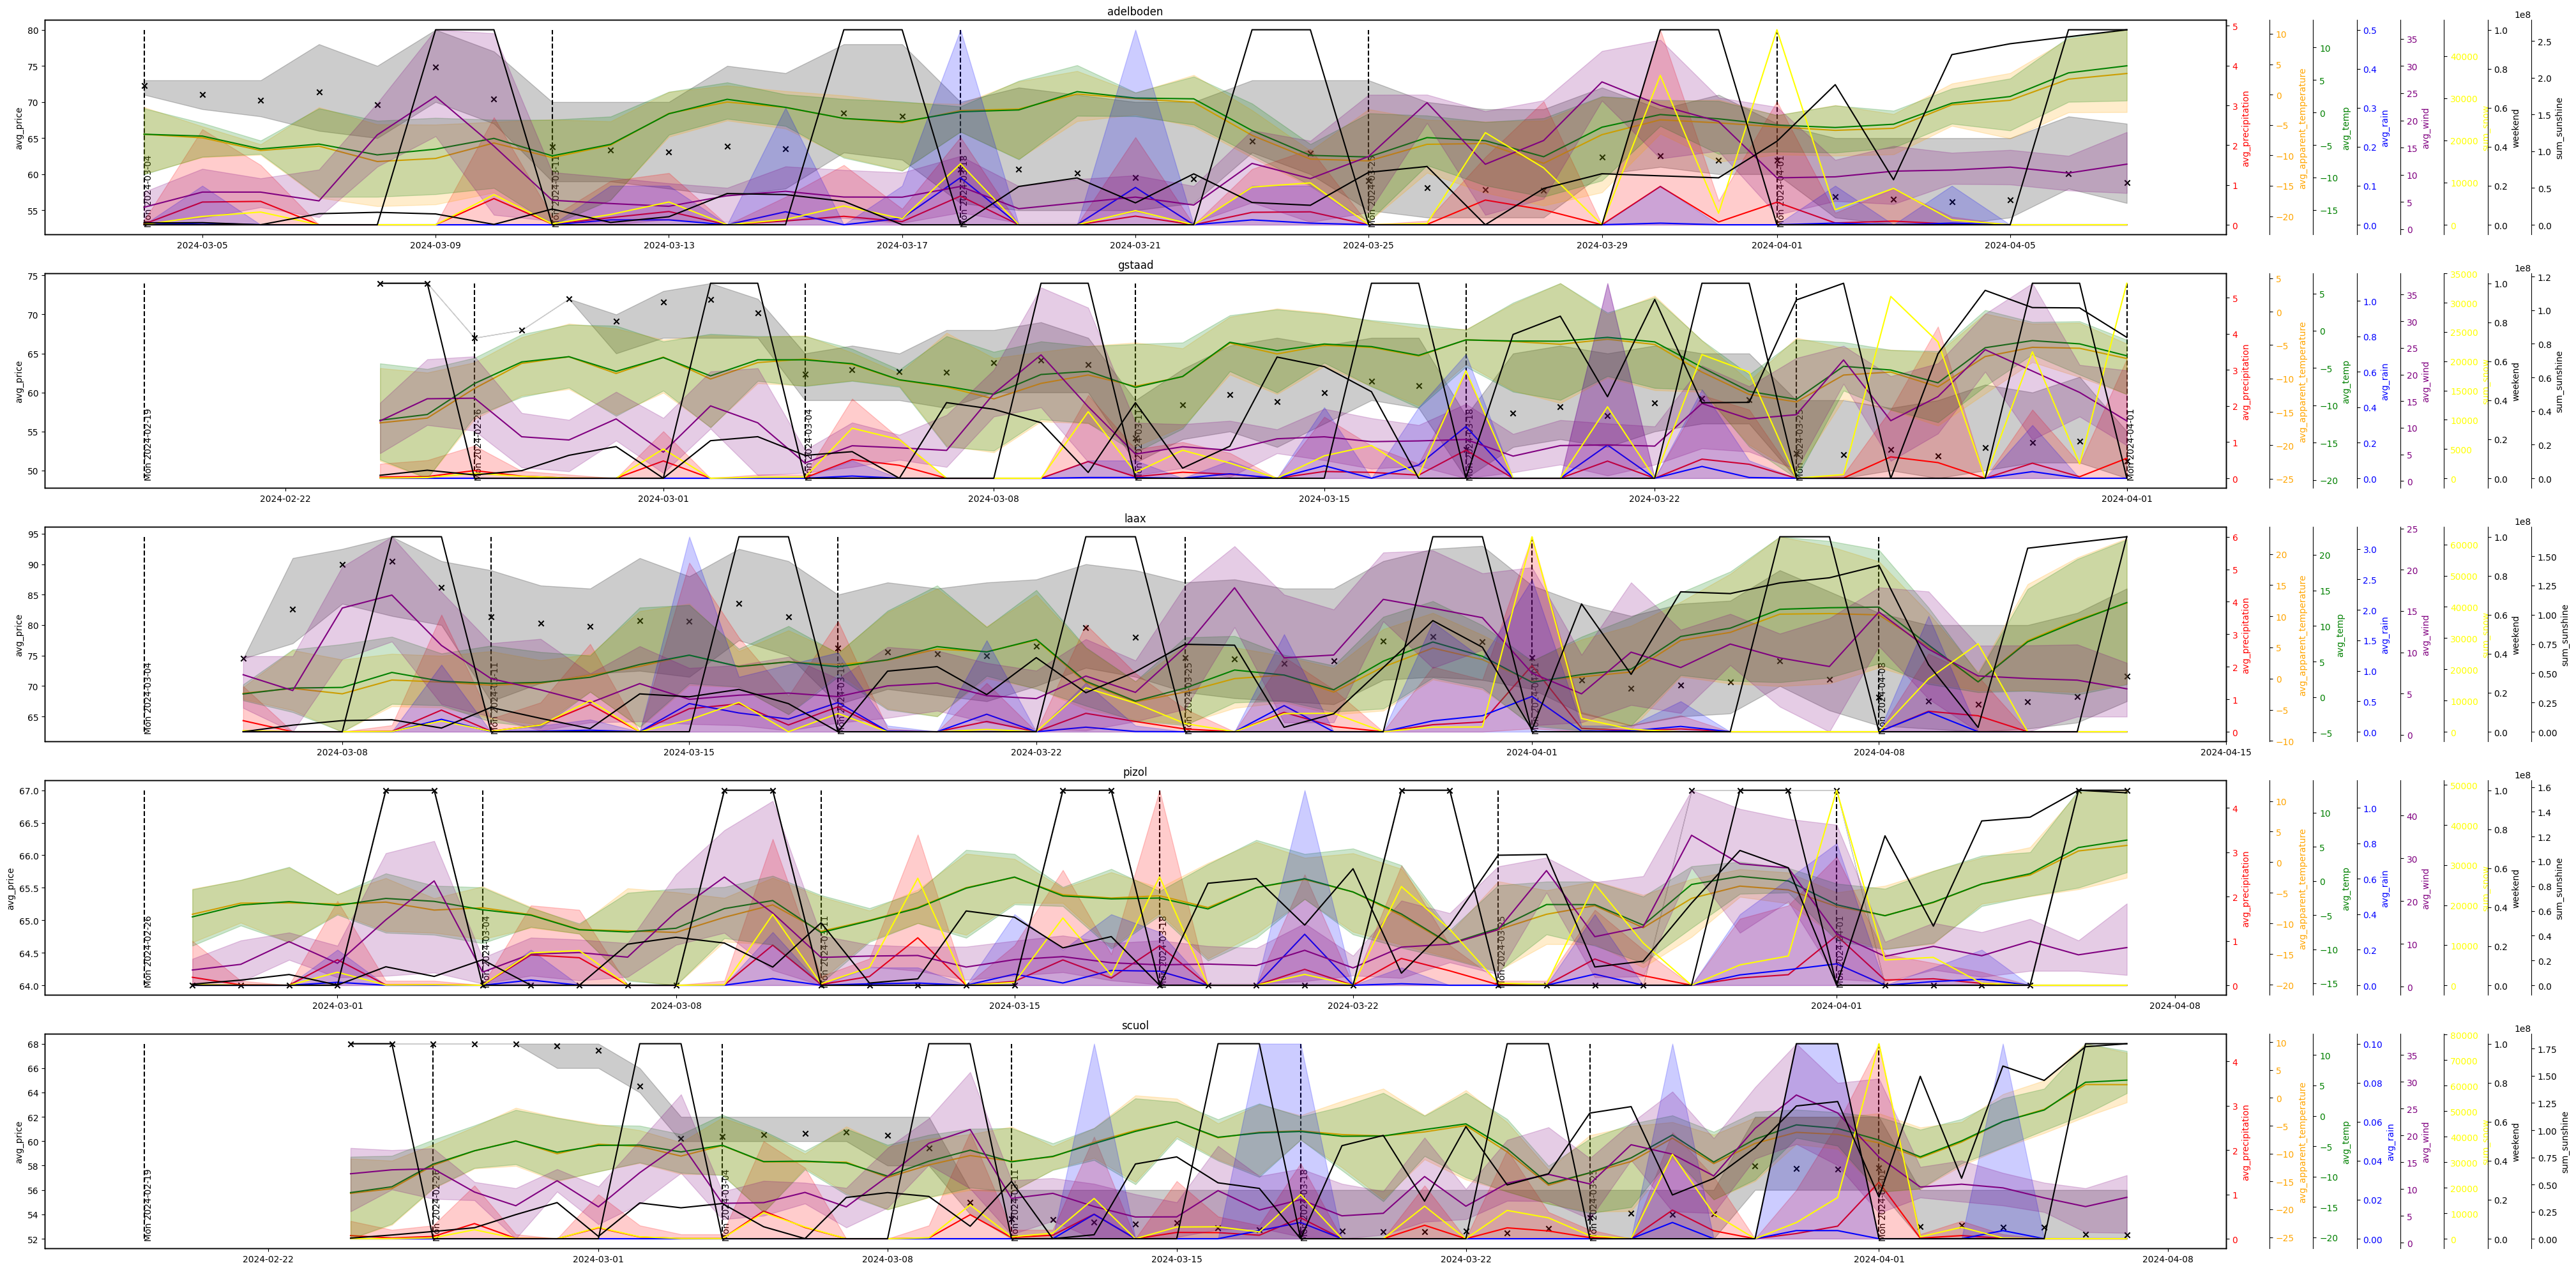

In [80]:
# Plot the data by resort
groups = data.groupby("resort")
fig = print_groups(
    groups, [
    ('avg_price', 'black', ["min_price", "max_price"]),
    ('avg_precipitation', 'red', ["max_precipitation", "min_precipitation"]),
    ('avg_apparent_temperature', 'orange', ["max_apparent_temperature", "min_apparent_temperature"]),
    ('avg_temp', 'green', ["max_temp", "min_temp"]),
    ('avg_rain', 'blue', ["max_rain", "min_rain"]),
    ('avg_wind', 'purple', ["max_wind", "min_wind"]),
    ('sum_snow', 'yellow', []),
    ('weekend', 'black', []),
    ('sum_sunshine', 'black', [])
])

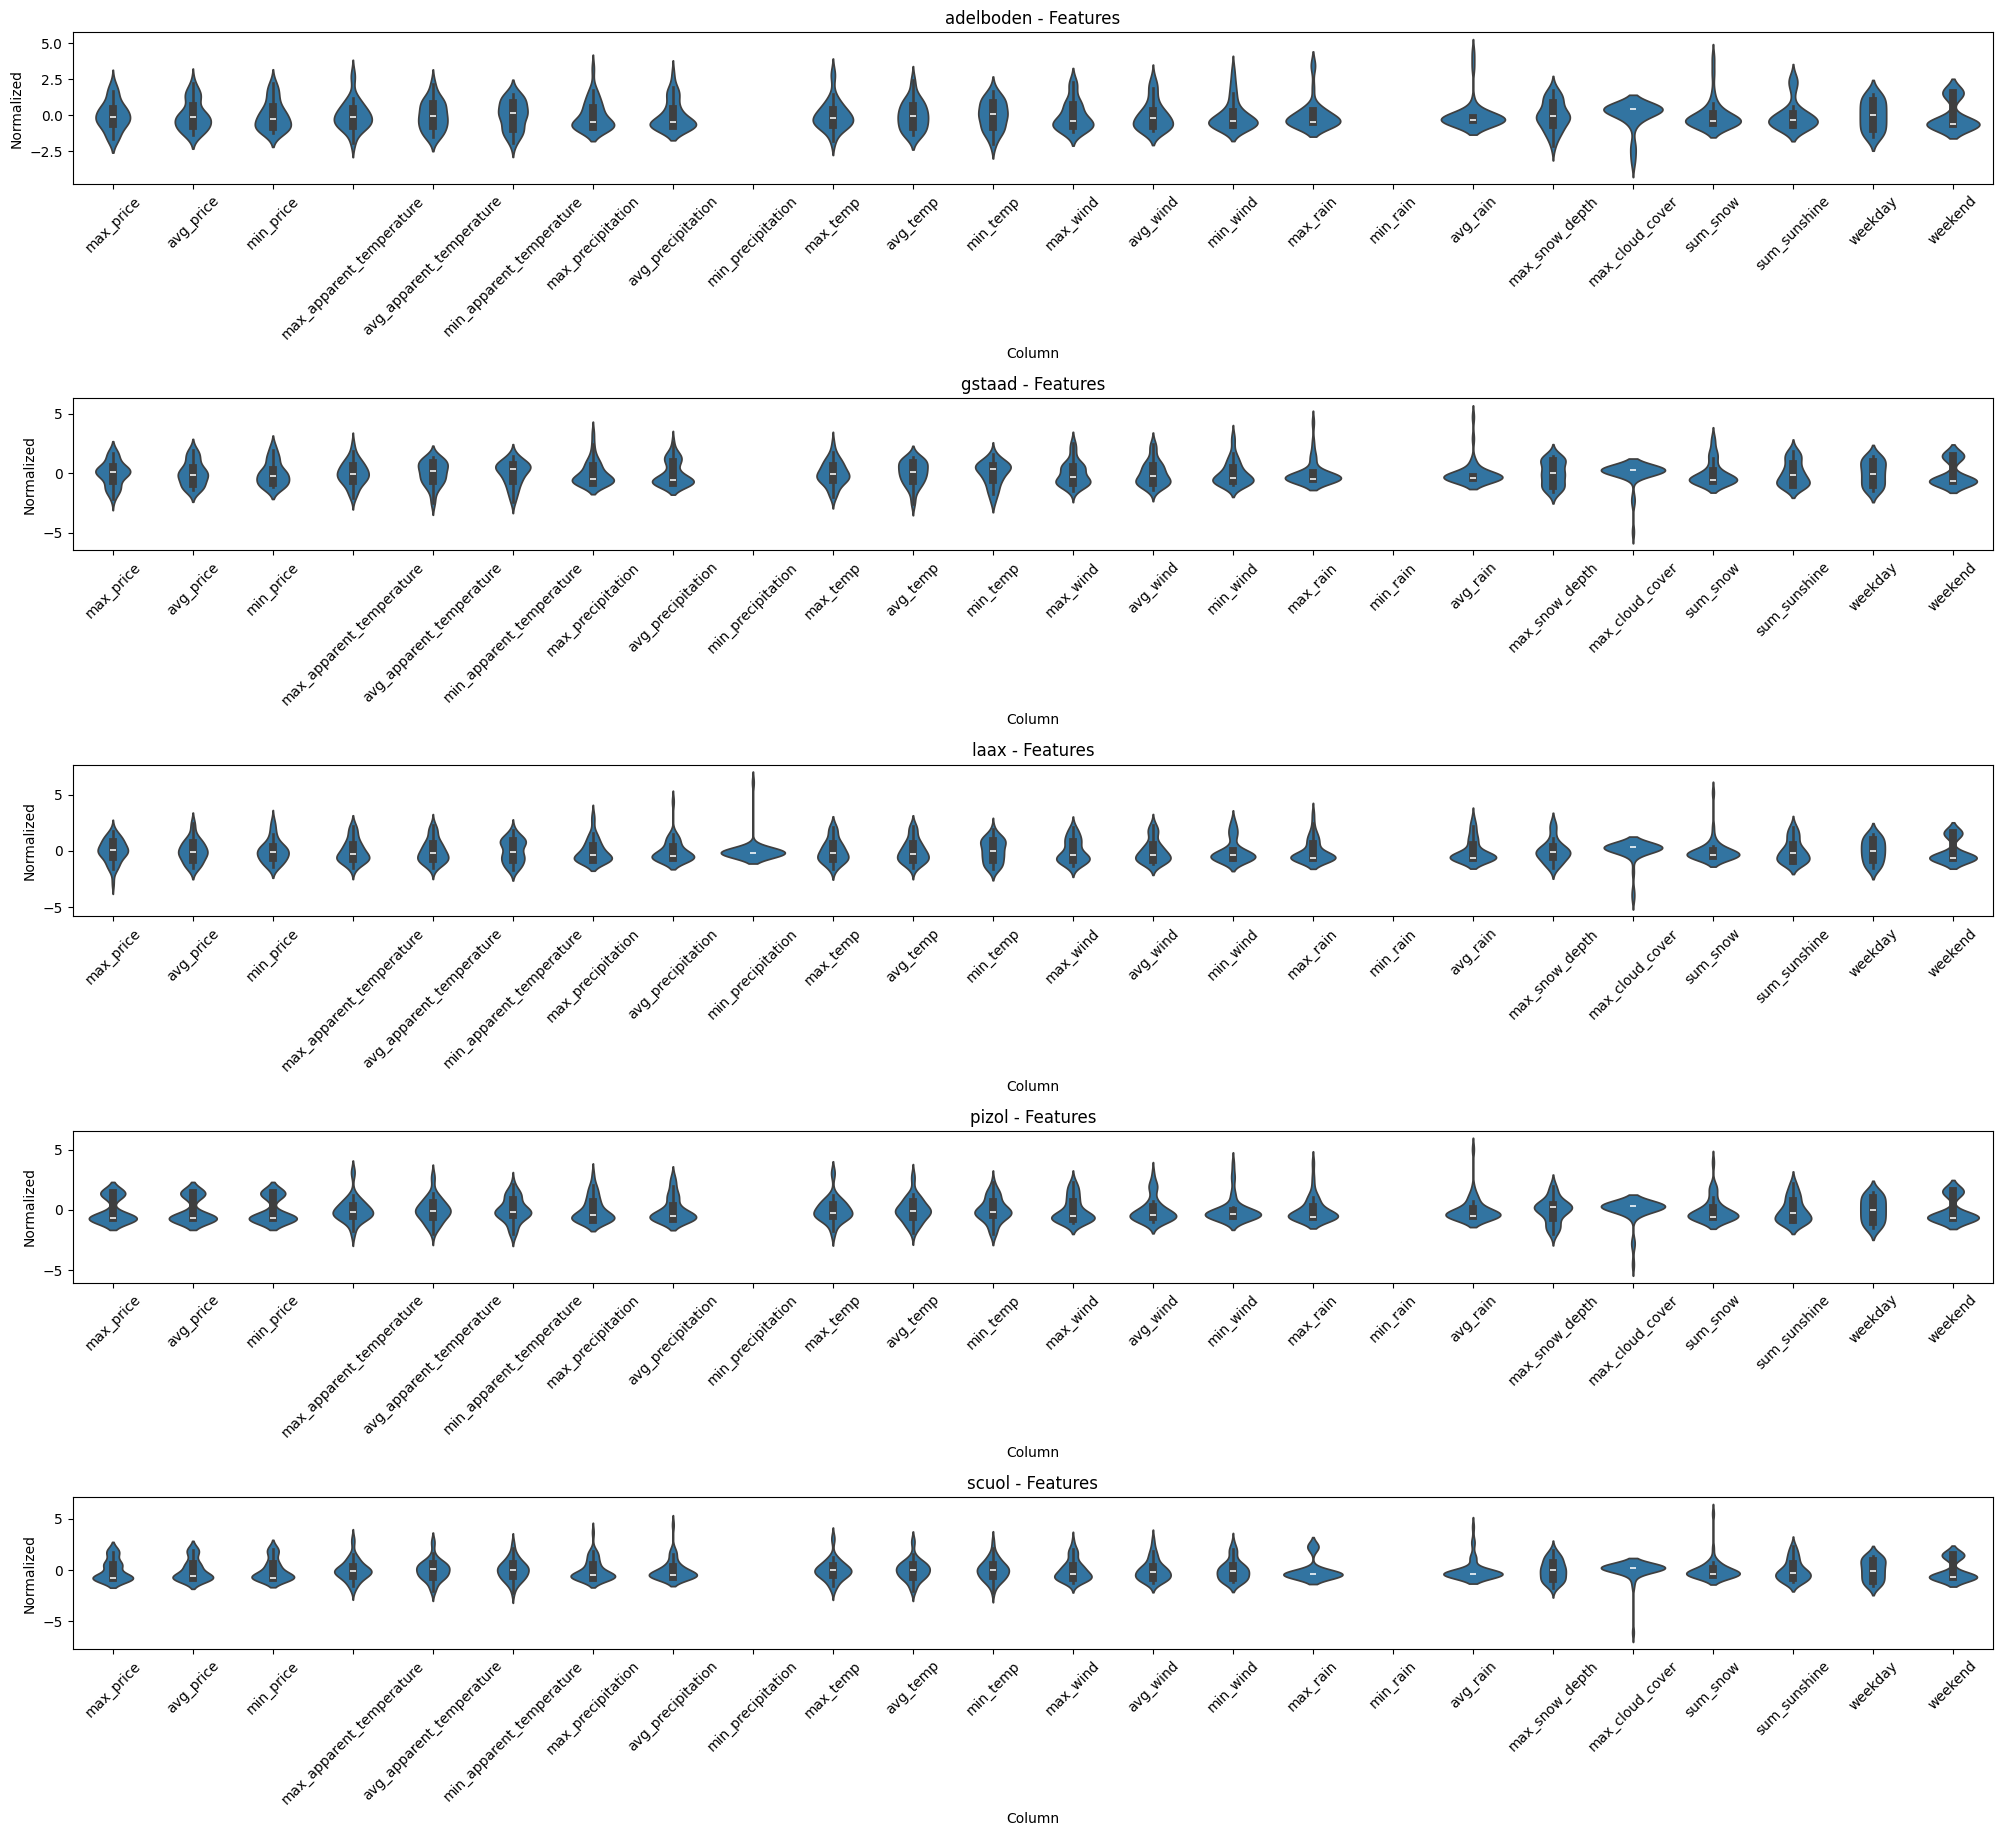

In [81]:
groups = data.groupby("resort")
fig = print_violins(groups, drop_cols=["date", "resort"])

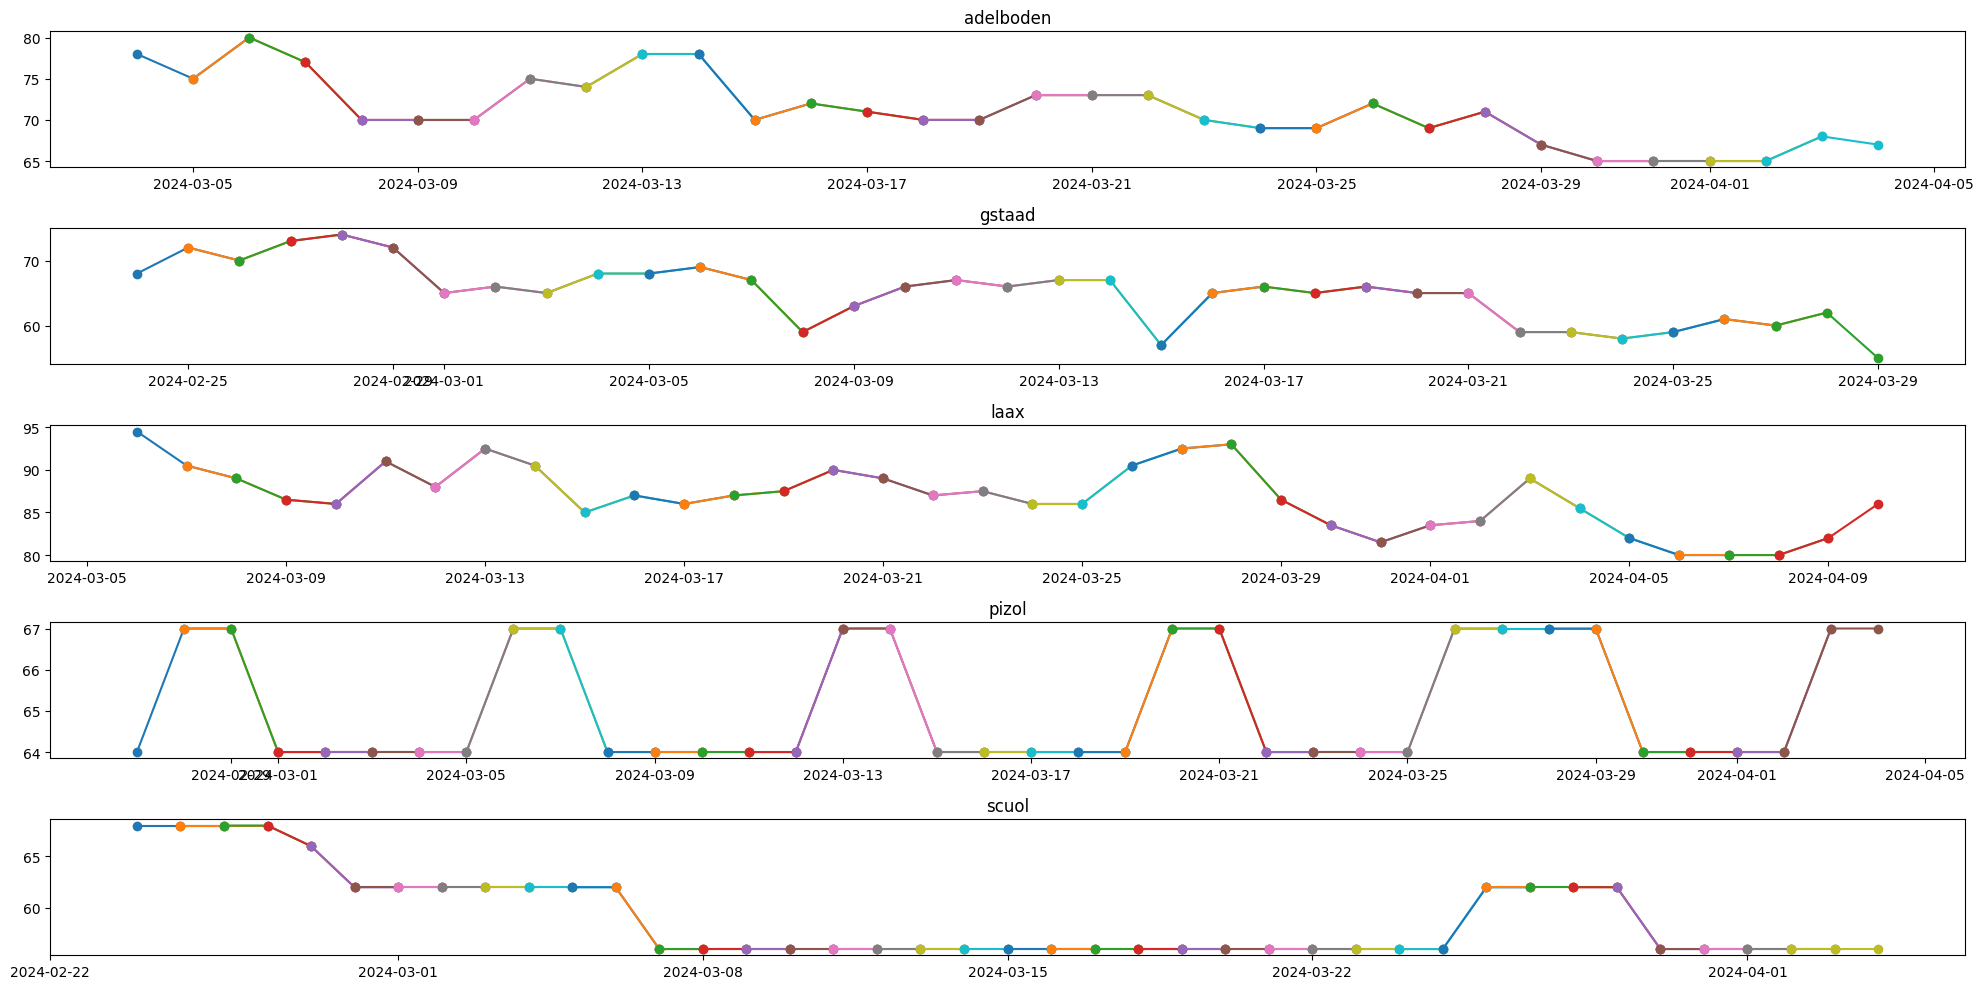

In [235]:
# Prepare the data
groups = data.groupby("resort")

# Define the features and targets
selected_freatures = data[["max_price", "avg_temp", "max_wind", "avg_wind", "max_precipitation", "avg_precipitation", "sum_snow", "weekend"]].columns
selected_targets = data[["max_price"]].columns

# Define the window size (7 days input and 3 days output)
X_WINDOW_SIZE = 3
Y_WINDOW_SIZE = 3

# Cunk the data
data_chunks = []
for group_index, (group_name, df) in enumerate(groups):
    # d_mean = df_raw["max_price"].mean()
    # d_std = df_raw["max_price"].std()
    # df = df_raw.copy()
    # df['max_price'] = (df_raw['max_price']-d_mean)/d_std

    df["price_surge"] = df["max_price"] - df["min_price"]
    for index in range(len(df.index) - (X_WINDOW_SIZE + Y_WINDOW_SIZE -1)):
        date = df.iloc[index].date
        feature_df = df[selected_freatures]
        target_df = df[selected_targets]
        X = np.array(
            feature_df.iloc[index:index+X_WINDOW_SIZE],
            dtype=np.float32
        )
        Y = np.array(
            target_df.iloc[index+X_WINDOW_SIZE-(X_WINDOW_SIZE-Y_WINDOW_SIZE):index+X_WINDOW_SIZE+Y_WINDOW_SIZE],
            dtype=np.float32
        )
        data_chunks.append((
            np.reshape(X, (X.shape[0], 1, X.shape[1])),
            np.reshape(Y, (Y.shape[0], 1, Y.shape[1])),
            date,
            group_name
        ))

fig = plt.figure(figsize=(20, 10))
# Verify the data actually looks like what we expect
for index, (group_name, group) in enumerate(itertools.groupby(data_chunks, key=lambda x: x[3])):
    axis = fig.add_subplot(
        5,1,index+1,
        title=group_name
    )
    X, Y, dates, _ = zip(*group)
    for gi, y in list(enumerate(Y)):
        base = X_WINDOW_SIZE - Y_WINDOW_SIZE
        labels = {}
        for idx, val in enumerate(y[base:]):
            date = datetime.datetime.strptime(dates[gi], "%Y-%m-%d") + datetime.timedelta(days=base + idx + (X_WINDOW_SIZE - Y_WINDOW_SIZE))
            labels[date] = val[0][0]
        axis.plot(labels.keys(), labels.values(), marker="o")

fig.tight_layout()

In [261]:
def get_model(metrics, lr=0.01):
    # Define the model architecture
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_WINDOW_SIZE, len(selected_freatures))))
    model.add(keras.layers.Conv1D(
        filters=128,
        kernel_size=3,
        strides=7,
        padding="causal"
    ))
    model.add(keras.layers.LSTM(64, return_sequences=False))
    model.add(keras.layers.LeakyReLU(negative_slope=0.3))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.LeakyReLU(negative_slope=0.3))
    model.add(keras.layers.Dense(Y_WINDOW_SIZE * len(selected_freatures)))
    model.add(keras.layers.Reshape(target_shape=(Y_WINDOW_SIZE, len(selected_freatures))))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.MeanSquaredError(),
        metrics=metrics
    )

    return model

def split_data(shuffled_data, train_size=0.8):
    train_val_split = int(len(shuffled_data) * train_size)
    X_train, Y_train, dates_train, _ = zip(*shuffled_data[:train_val_split])
    X_val, Y_val, dates_val, _ = zip(*shuffled_data[train_val_split:])

    return X_train, Y_train, dates_train, X_val, Y_val, dates_val

def fit_model(model, X_train, Y_train, X_val, Y_val, epochs=100, logdir="logs", patience=20):
    # Fit the model
    return model.fit(
        X_train, Y_train, 
        batch_size=len(X_train)//3,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=patience),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0000001, patience=3, mode='min'),
            keras.callbacks.TerminateOnNaN(),
            keras.callbacks.TensorBoard(log_dir=logdir),
        ]
    )

In [263]:
MAX_EPOCS = 1000
METRIC = "mean_squared_error"

# Keep track of the best model
hist = {}

# Shuffle the data and split it into folds
shuffled_data = data_chunks.copy()
random.shuffle(shuffled_data)

resorts = set([a[3] for a in data_chunks])
NUMBER_FOLDS = len(resorts)
print(f"Using total of {len(shuffled_data)} data points in {NUMBER_FOLDS} folds")

for fold_no, resort_name in enumerate(resorts):
    # length = len(shuffled_data)
    # size = length // (NUMBER_FOLDS)
    # start_index = fold_no * size #length // 2 - length // 10
    # end_index = start_index + size #length // 2 + length // 10

    in_fold_data = [d for d in shuffled_data if d[3] != resort_name] #[:start_index] + shuffled_data[end_index:]
    out_fold_data = [d for d in shuffled_data if d[3] == resort_name] #shuffled_data[start_index:end_index]

    # Split the data into training and validation
    X_train, Y_train, dates_train, X_val, Y_val, dates_val = split_data(in_fold_data, train_size=0.8)
    print(f"Fold {fold_no} has {len(in_fold_data)} data points with {len(X_train)} training and {len(X_val)} validation data points and {len(out_fold_data)} test data points. (excluded resort: {resort_name})")

    # Define the model architecture
    model = get_model(metrics=[METRIC, "mean_absolute_error"], lr=0.0001)

    # Fit the model
    history = fit_model(model, X_train, Y_train, X_val, Y_val, epochs=MAX_EPOCS, logdir=f"logs-{fold_no}", patience=100)

    # Evaluate the model
    X_test, Y_test, dates_test, _ = zip(*out_fold_data)
    scores = model.evaluate(X_test, Y_test, verbose=2, return_dict=True)

    # Save the model
    model.save(f'fold-{fold_no}.keras')
    hist[fold_no] = {
        "history": history,
        "scores": scores,
        "model": model
    }


Using total of 172 data points in 5 folds
Fold 0 has 139 data points with 111 training and 28 validation data points and 33 test data points. (excluded resort: gstaad)
1/1 - 0s - 407ms/step - loss: 836.6183 - mean_absolute_error: 25.7036 - mean_squared_error: 836.6183
Fold 1 has 138 data points with 110 training and 28 validation data points and 34 test data points. (excluded resort: laax)
1/1 - 0s - 283ms/step - loss: 457.7284 - mean_absolute_error: 20.0881 - mean_squared_error: 457.7284
Fold 2 has 133 data points with 106 training and 27 validation data points and 39 test data points. (excluded resort: scuol)
1/1 - 0s - 258ms/step - loss: 141.3793 - mean_absolute_error: 10.6444 - mean_squared_error: 141.3793
Fold 3 has 136 data points with 108 training and 28 validation data points and 36 test data points. (excluded resort: pizol)
1/1 - 0s - 258ms/step - loss: 62.2827 - mean_absolute_error: 7.1338 - mean_squared_error: 62.2827
Fold 4 has 142 data points with 113 training and 29 valid

/tmp/ipykernel_1756/2699457091.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


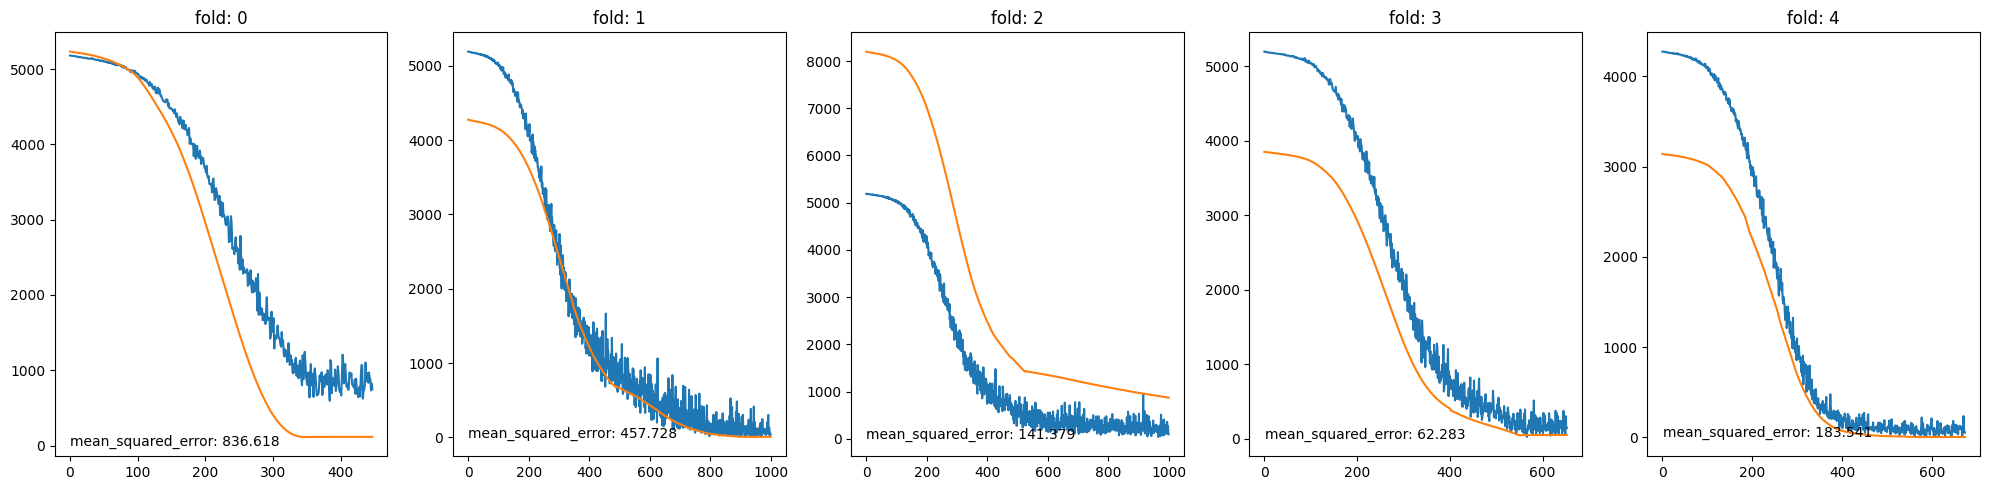

In [267]:
fig = plt.figure(figsize=(20, 5))
for index in hist:
    history = hist[index].get("history")
    axis = fig.add_subplot(
        1,len(hist),index+1,
        title=f"fold: {index}"
    )
    axis.text(0.5, 0.5, f"{METRIC}: {round(hist[index].get('scores').get(METRIC),3)}")
    axis.plot(history.history[METRIC])
    axis.plot(history.history["val_" + METRIC])

fig.tight_layout()
fig.show()

/tmp/ipykernel_1756/4045327720.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


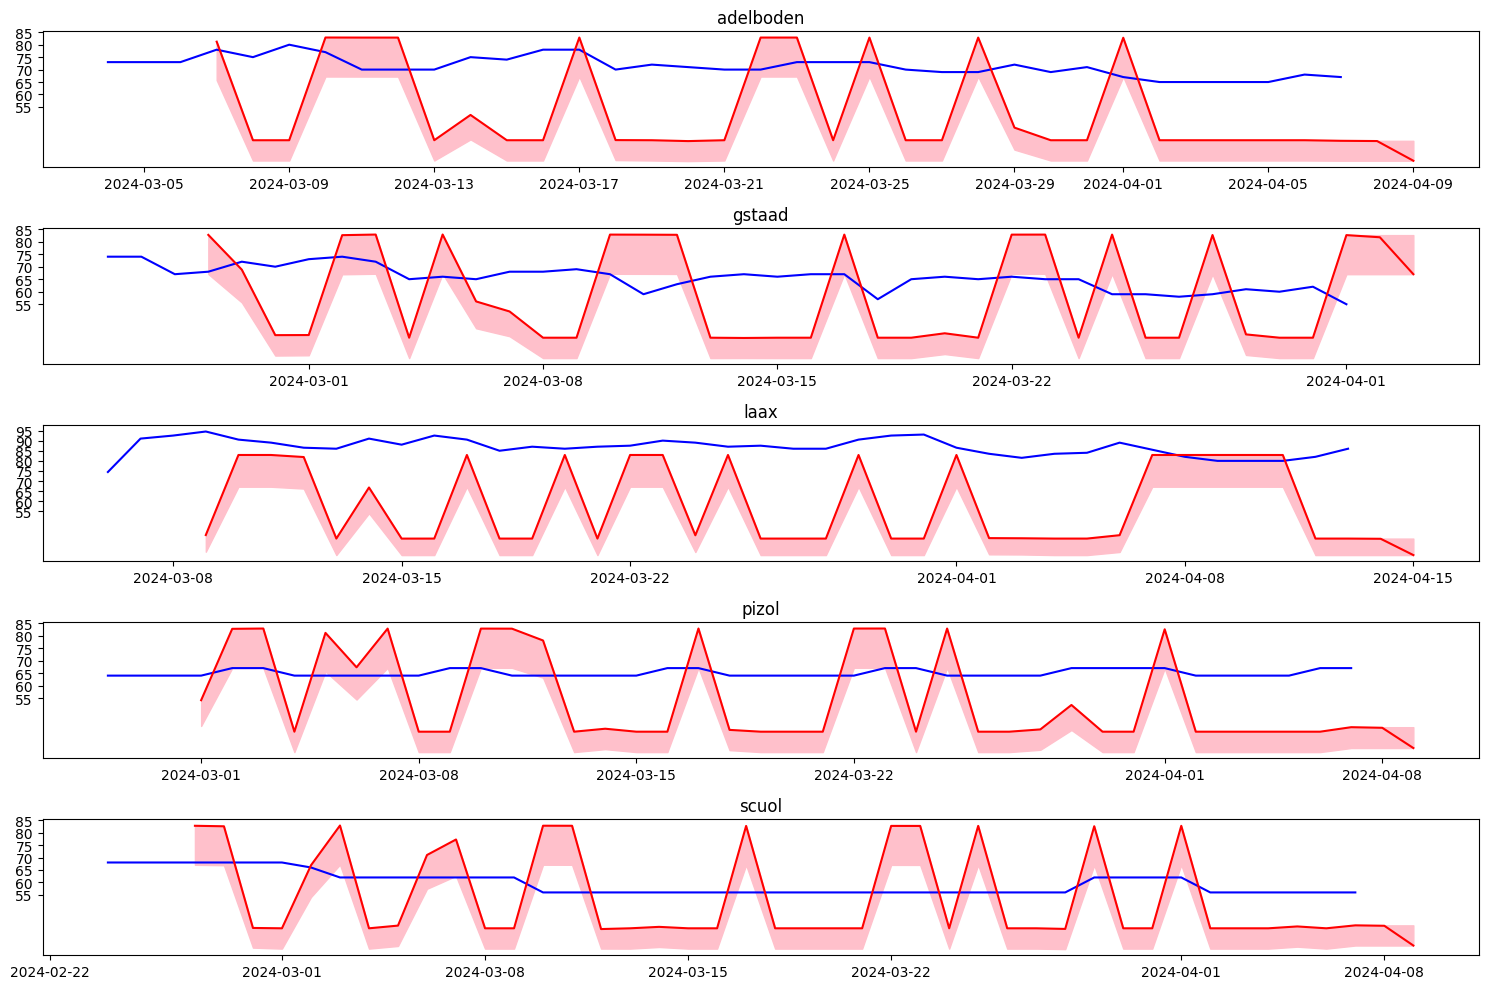

In [266]:
fig = plt.figure(figsize=(15, 10))

model = keras.models.load_model('fold-0.keras')
for group_index, (group_name, df) in list(enumerate(groups)):
    pp = {}
    rr = len(df.index) - (X_WINDOW_SIZE)
    for index in range(rr):
        date = datetime.datetime.strptime(df.iloc[index].date, "%Y-%m-%d")
        feature_df = df[selected_freatures]
        target_df = df[selected_targets]
        # for selected_target in selected_targets:
        #     d_mean = df[selected_target].mean()
        #     d_std = df[selected_target].std()
        #     target_df[selected_target] = (df[selected_target]-d_mean)/d_std
        
        X = np.array(
            feature_df.iloc[index:index+X_WINDOW_SIZE],
            dtype=np.float32
        )
        model_preds = model(np.reshape(X, (X.shape[0], 1, X.shape[1])))
        preds = [p.numpy()[-1] for p in model_preds[0]]

        #preds = [p * d_std + d_mean for p in preds]
        p_date = date + datetime.timedelta(days=X_WINDOW_SIZE)
        if p_date not in pp:
            pp[p_date] = {"0": preds[0], "max": preds[0], "min": preds[0]}

        pred_max = max(preds[0:3])
        pred_min = min(preds[0:3])

        if pred_max > pp[p_date]["max"]:
            pp[p_date]["max"] = pred_max

        if pred_min < pp[p_date]["min"]:
            pp[p_date]["min"] = pred_min

        if index == rr - 1:
            pp[p_date + datetime.timedelta(days=1)] = {"0": preds[1], "max": pred_max, "min": pred_min}
            pp[p_date + datetime.timedelta(days=2)] = {"0": preds[2], "max": pred_max, "min": pred_min}

    d = pd.DataFrame.from_dict(pp, orient='index')

    axis = fig.add_subplot(
        5,1,group_index+1,
        yticks=[55,60,65,70,75,80,85,90,95,100],
        title=group_name
    )
    axis.plot(df.index, df["max_price"], color="blue", label="price")
    axis.plot(d.index, d["0"], color="red", label="1 day prediction")
    axis.fill_between(d.index, d["min"], d["max"], color="pink", label="3 day prediction")

fig.tight_layout()
fig.show()